# Workflow to analyze the rift catalog

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime as dt
%matplotlib inline
import matplotlib 
from netCDF4 import Dataset    
import os

dataset_path = '/data/fast0/datasets/'

plt.style.use('fivethirtyeight')
# matplotlib.rcParams['ytick.labelsize'] = 'large'
# matplotlib.rcParams['xtick.labelsize'] = 'large'
# matplotlib.rcParams['axes.labelsize'] = 'large'


import numpy as np
import rasterio
from rasterio.plot import show
import pickle

from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer

import pandas as pd
import geopandas as gpd

from scipy import stats

In [2]:
# !pip3 install pickle5
import sys
print(sys.version)

3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]


In [3]:
# (option, useful for Brunt / Halloween)
# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


## Load the GPS Data

In [4]:
# Load these now so that we can plot the GPS locations on the map
gps = pd.read_csv(dataset_path + 'bas_marsh_monthly_halloween.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

## Load ITS_LIVE velocities

In [5]:

# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]


# d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
d = Dataset(dataset_path + 'ANT_G0120_0000.nc', 'r')
# print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)





# Calculate strains

dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


In [6]:
#rift_obs

rift_obs_input_path = '/data/fast1/arc/rift_obs'
shelf_name = 'brunt'
rift_obs_input_file_name = os.path.join(rift_obs_input_path, shelf_name + '.pkl')

with open(rift_obs_input_file_name, 'rb') as handle:
    rift_obs = pickle.load(handle)
    
rift_obs = gpd.GeoDataFrame(
    rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))
    
display(rift_obs)


,d-start,d-end,x-start,y-start,x-end,y-end,x-centroid,y-centroid,lat-centroid,lon-centroid,width,time,rgt,azimuth,sigma,h,beam,data_row,confidence,geometry
0,1.905276e+06,1.905551e+06,-565613.247077,1.819384e+06,-565658.698762,1.819658e+06,-565635.972919,1.819521e+06,-72.592951,-17.268946,274.871817,2018-10-14 04:18:16.593302+00:00,237,-172.192581,0.167704,9.256703,2l,1,n/a,POINT (-565635.973 1819520.879)
1,1.905278e+06,1.905533e+06,-565624.512822,1.819382e+06,-565666.793309,1.819636e+06,-565645.653066,1.819509e+06,-72.593025,-17.269328,255.248344,2018-10-14 04:18:16.593302+00:00,237,-172.185532,0.130750,8.349120,2r,4,n/a,POINT (-565645.653 1819509.216)
2,1.538080e+06,1.538391e+06,-677131.150364,1.381008e+06,-677312.674234,1.381265e+06,-677221.912299,1.381137e+06,-75.911160,-26.120407,310.497286,2018-10-16 17:43:10.150777+00:00,276,-9.128908,0.087139,8.390498,1l,18,n/a,POINT (-677221.912 1381136.567)
3,1.538556e+06,1.538769e+06,-677408.898135,1.381402e+06,-677533.495836,1.381578e+06,-677471.196986,1.381490e+06,-75.907287,-26.122949,213.509186,2018-10-16 17:43:10.150777+00:00,276,-9.126936,0.178161,7.286198,1l,18,n/a,POINT (-677471.197 1381489.898)
4,1.544986e+06,1.545248e+06,-681163.279306,1.386723e+06,-681316.346561,1.386939e+06,-681239.812934,1.386831e+06,-75.848739,-26.161219,261.761740,2018-10-16 17:43:10.150777+00:00,276,-9.097244,0.311341,4.297507,1l,18,n/a,POINT (-681239.813 1386830.890)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9608,2.182250e+06,2.182943e+06,15021.079340,2.182198e+06,14939.700837,2.182892e+06,14980.390089,2.182545e+06,-70.106342,0.393256,693.381569,2021-07-12 16:01:13.041242+00:00,290,-7.147538,0.151661,8.691294,2r,15320,n/a,POINT (14980.390 2182545.385)
9609,2.186238e+06,2.188733e+06,17947.331761,2.186164e+06,17650.613856,2.188662e+06,17798.972809,2.187413e+06,-70.062641,0.466205,2495.812282,2021-07-12 16:01:13.041242+00:00,290,-7.138965,0.073643,7.539163,3r,15321,n/a,POINT (17798.973 2187413.140)
9610,1.599338e+06,1.599688e+06,-563251.935063,1.496873e+06,-563426.612673,1.497182e+06,-563339.273868,1.497028e+06,-75.355650,-20.621580,349.984604,2021-07-12 17:35:30.334032+00:00,291,-8.866313,0.322381,14.107074,3l,15324,n/a,POINT (-563339.274 1497027.563)
9611,1.596125e+06,1.598652e+06,-561560.868897,1.494077e+06,-562824.492616,1.496301e+06,-562192.680757,1.495189e+06,-75.374899,-20.606314,2527.073329,2021-07-12 17:35:30.334032+00:00,291,-8.864874,0.048220,16.409516,3r,15327,n/a,POINT (-562192.681 1495189.066)


## Plot just the Halloween crack  against the ITS_LIVE velocities

/tmp/ipykernel_1813425/689109959.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',MarkerSize=20)
/tmp/ipykernel_1813425/689109959.py:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',MarkerSize=20)
/tmp/ipykernel_1813425/689109959.py:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',MarkerSize=20)
/tmp/ipykernel_1813425/689109959.py:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)


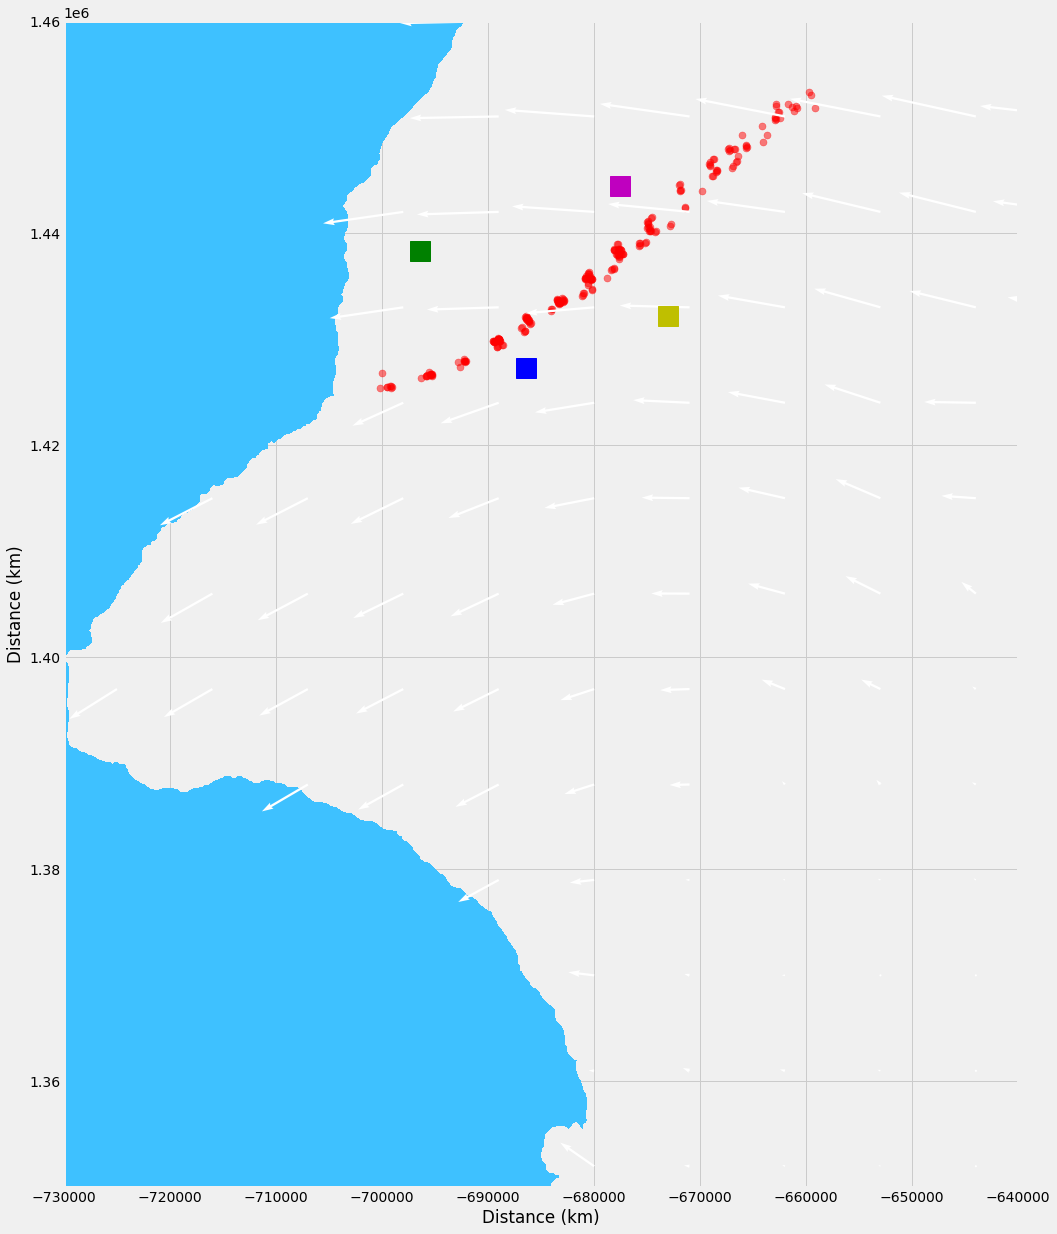

In [8]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]


fig3,ax3=plt.subplots(figsize=(20,20))

# Subset the data to the Halloween Crack polygon

ho = rift_obs[rift_obs.within(poly)]
with open('/home/ram21/notebooks/brunt-is2-rifts/halloween.pickle', 'wb') as handle:
    pickle.dump(ho, handle, protocol=pickle.HIGHEST_PROTOCOL)

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))

image_file = dataset_path + 'moa125_2014_hp1_v01.tif'
# sat_data = rasterio.open(image_file)
# show(sat_data,cmap="gray",ax=ax3,vmin=0,vmax=1e5)

c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',MarkerSize=20)
plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',MarkerSize=20)
plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',MarkerSize=20)
plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
# plt.plot(box_x,box_y)
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [9]:

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)
ho

/home/ram21/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,d-start,d-end,x-start,y-start,x-end,y-end,x-centroid,y-centroid,lat-centroid,lon-centroid,...,azimuth,sigma,h,beam,data_row,confidence,geometry,rift-angle,rift-angle-xy,actual-width
25,1.587953e+06,1.588167e+06,-700117.322503,1.425283e+06,-700241.968014,1.425460e+06,-700179.645258,1.425371e+06,-75.459428,-26.161478,...,-8.901688,0.147443,3.023341,3r,23,n/a,POINT (-700179.645 1425371.259),97.085291,97.085291,205.525979
28,1.587936e+06,1.588325e+06,-678724.361415,1.435575e+06,-678834.656400,1.435952e+06,-678779.508908,1.435763e+06,-75.458790,-25.303171,...,-171.079163,0.067576,2.040557,2r,28,n/a,POINT (-678779.509 1435763.493),75.816947,75.816947,357.266527
179,1.587478e+06,1.587906e+06,-680077.010088,1.434428e+06,-680320.974033,1.434785e+06,-680198.992061,1.434607e+06,-75.462761,-25.367326,...,-8.904643,0.141080,3.995478,1l,330,n/a,POINT (-680198.992 1434606.581),75.816947,75.816947,425.789701
182,1.589436e+06,1.589785e+06,-675084.165148,1.438947e+06,-675283.648869,1.439239e+06,-675183.907009,1.439093e+06,-75.445377,-25.134712,...,-8.902081,0.105899,2.694658,3l,332,n/a,POINT (-675183.907 1439092.998),77.915449,77.915449,349.182307
189,1.587611e+06,1.588000e+06,-680057.107923,1.434584e+06,-680278.196791,1.434910e+06,-680167.652357,1.434747e+06,-75.461734,-25.364134,...,-8.893535,0.073261,2.999994,1r,333,n/a,POINT (-680167.652 1434746.966),75.816947,75.816947,387.202857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9566,1.590212e+06,1.590950e+06,-677659.686089,1.438593e+06,-677870.190997,1.439311e+06,-677764.938543,1.438952e+06,-75.436585,-25.221043,...,-171.112213,0.081255,2.427637,2l,15311,n/a,POINT (-677764.939 1438951.817),77.915449,77.915449,689.858845
9572,1.588922e+06,1.589758e+06,-680340.683801,1.435900e+06,-680578.975394,1.436712e+06,-680459.829598,1.436306e+06,-75.447829,-25.349569,...,-171.105148,0.060543,1.523459,3l,15312,n/a,POINT (-680459.830 1436306.451),75.816947,75.816947,768.881331
9586,1.590919e+06,1.591736e+06,-674890.402263,1.440675e+06,-675122.768042,1.441469e+06,-675006.585152,1.441072e+06,-75.429822,-25.098668,...,-171.106293,0.133099,4.938108,1r,15313,n/a,POINT (-675006.585 1441071.975),74.565869,74.565869,744.229538
9590,1.590226e+06,1.590964e+06,-677746.572776,1.438568e+06,-677957.037121,1.439285e+06,-677851.804948,1.438926e+06,-75.436458,-25.224264,...,-171.101456,0.053447,2.436554,2r,15314,n/a,POINT (-677851.805 1438926.356),77.915449,77.915449,689.798421


## Perform advection correction
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough


In [10]:
time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for i,t in enumerate(time_vector):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y'])
        vy_new = vy_interp(state_vector['x'],state_vector['y'])
        
        # Calculate strain rates
        e11 =  vx_x(state_vector['x'],state_vector['y']) 
        e12 = (  vx_y(state_vector['x'],state_vector['y']) 
              +  vy_x(state_vector['x'],state_vector['y']) ) / 2
        e22 =  vy_y(state_vector['x'],state_vector['y']) 
        
        if state_vector['x'].size > 1:
            vx_new = np.diag( vx_new )
            vy_new = np.diag( vy_new )
            e11 = np.diag ( e11 )
            e12 = np.diag ( e12 )
            e22 = np.diag ( e22 )
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a","h"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

0. Found 1 new observations at time 2018-10-16 17:43:10.150777+00:00 with dt=inf
1. Found 1 new observations at time 2018-10-17 04:36:21.159767+00:00 with dt=0.001241888134395518
2. Found 4 new observations at time 2018-11-10 16:27:49.994267+00:00 with dt=0.06706114642748498
3. Found 4 new observations at time 2018-11-15 03:12:21.336990+00:00 with dt=0.012176824052621238
4. Found 1 new observations at time 2018-12-13 14:55:15.840583+00:00 with dt=0.0779962514130669
5. Found 4 new observations at time 2018-12-14 01:48:05.538331+00:00 with dt=0.001241212821887596
6. Found 2 new observations at time 2019-01-07 13:39:44.483041+00:00 with dt=0.06706146680070728
7. Found 4 new observations at time 2019-03-10 10:43:36.388446+00:00 with dt=0.16941186609263695
8. Found 5 new observations at time 2019-03-18 21:19:46.882504+00:00 with dt=0.023112356264671584
9. Found 6 new observations at time 2019-04-12 09:11:15.279099+00:00 with dt=0.06706113255111289
10. Found 3 new observations at time 2019-0

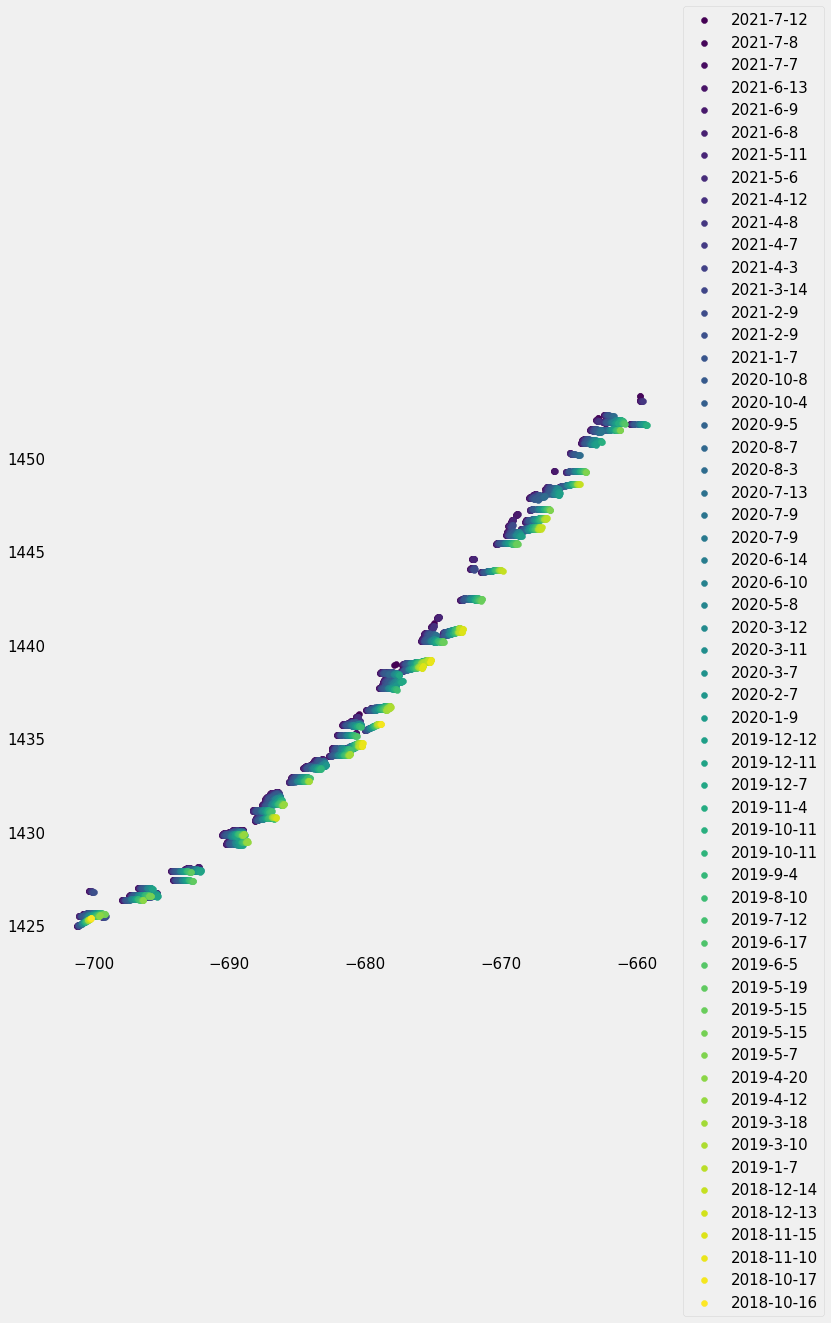

In [11]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
# plt.xlim((-694,-691))
# plt.ylim((1426,1429))
plt.show()

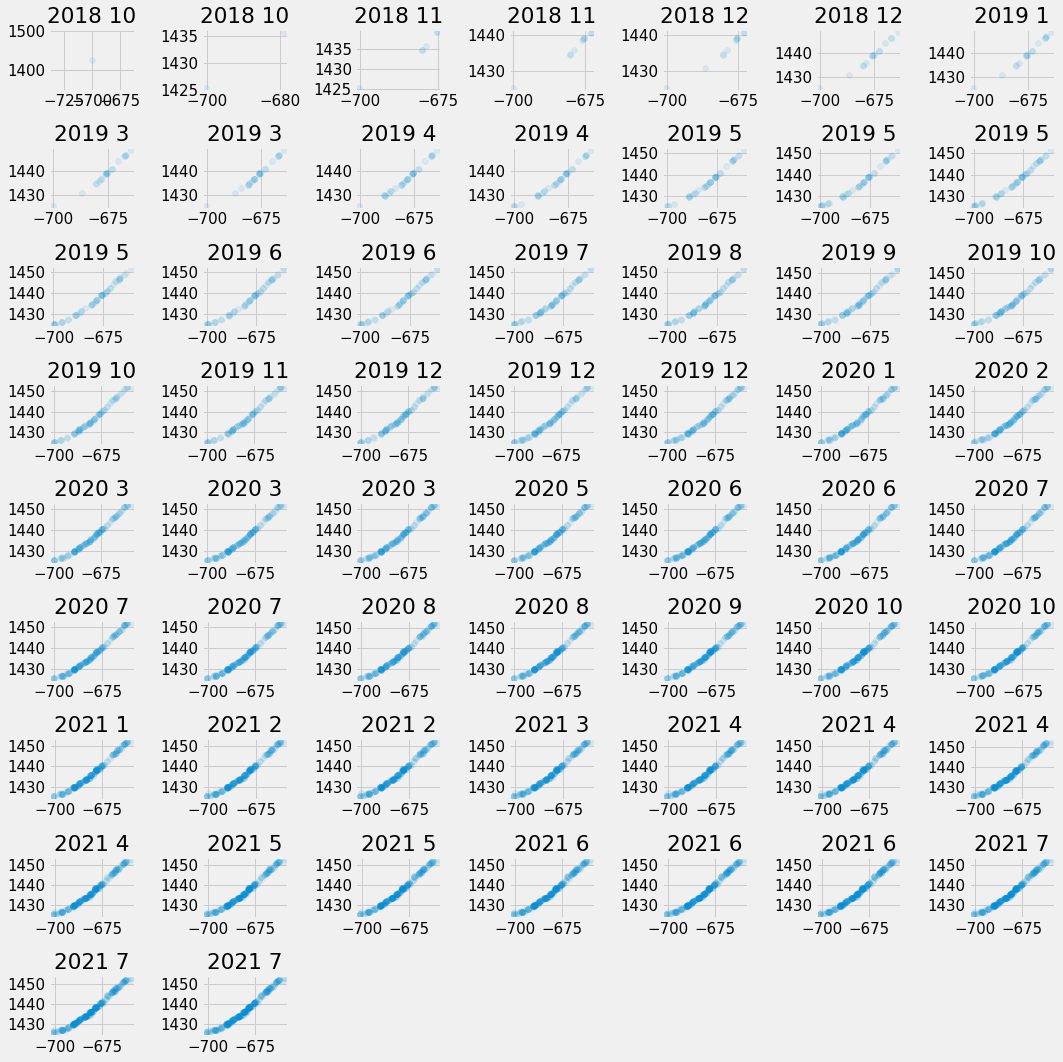

In [12]:
fig9,ax9 = plt.subplots(7, 9,sharex='all', sharey='all',figsize=(15,15))
#fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))
# fig9,ax9 = plt.subplots(7, 6,figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    #plt.subplot(6,7,1+i)
    plt.subplot(9,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
    plt.title('%d %d'%(t.year,t.month))
plt.tight_layout()
plt.show()

In [13]:
latest = list_of_state_vectors[-1]
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
times_h = ho['time'].apply(lambda x: (x- latest.iloc[0]['t']).days).values

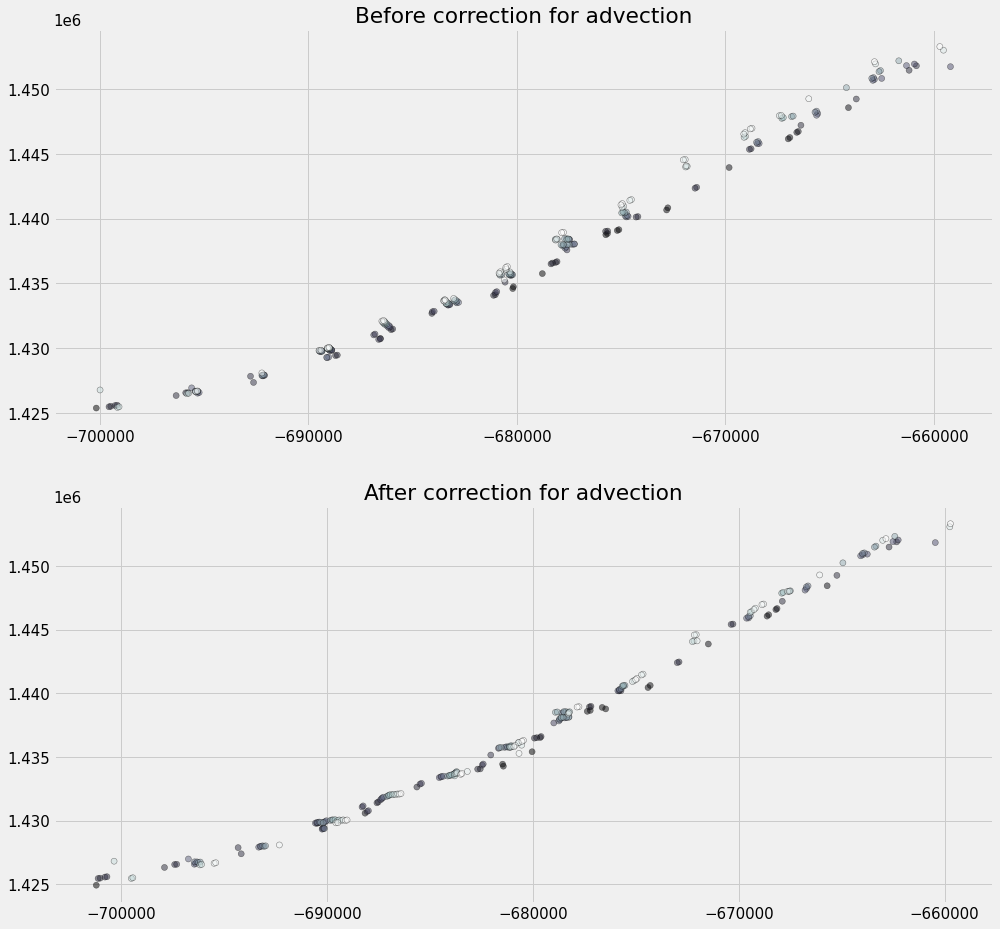

In [14]:
# Plot a snapshot
plt.subplots(2,1,figsize=(15,15))
ax=plt.subplot(2,1,1)
c=ax.scatter(ho['x-centroid'],ho['y-centroid'],c=times_h,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('Before correction for advection')

ax=plt.subplot(2,1,2)
c=ax.scatter(latest['x'],latest['y'],c=times,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('After correction for advection')
plt.show()

## Simple Model of Rift Opening

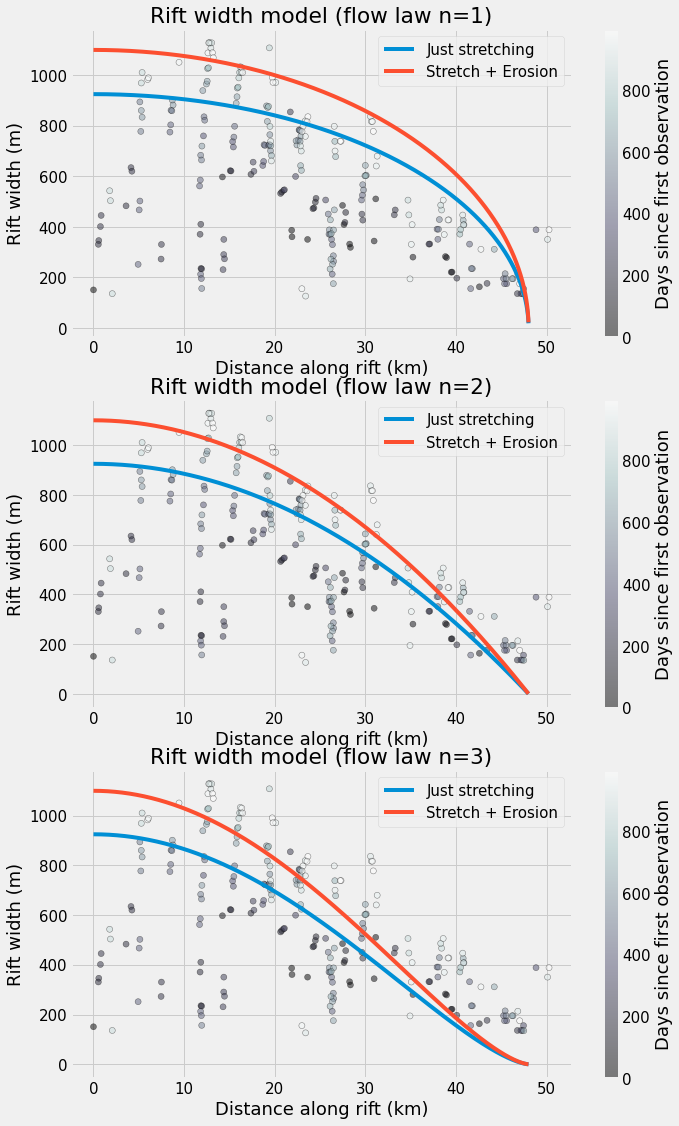

Stretching: 925.101370 m over 999.000000 days or 338.000000 m/y
Erosion + stretching: 1100.000000 m over 999.000000 days or 401.901902 m/y
Erosion is 15.899875 %


In [15]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 48
xx = np.arange(0,rift_len,0.01)

tmax = max(times)
rate = 338 / 365 #see next cell!
wmax = rate * tmax

wmax2 = 1100
rate2 = wmax2/tmax
r = np.sqrt(rift_len**2 - xx**2)





fig12 = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)


for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    ax.plot(xx,wmax* (r/rift_len)**n,'-',label='Just stretching')
    ax.plot(xx,wmax2* (r/rift_len)**n,'-',label='Stretch + Erosion')
    ax.legend()

    c=ax.scatter(dist/1e3,latest['w'],c=times,cmap='bone',label=latest['t'],\
                 alpha=0.5,edgecolors='k')
    cbar=plt.colorbar(c)

    cbar.set_label('Days since first observation')
    ax.set_xlabel('Distance along rift (km)')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)



plt.show()

print('Stretching: %f m over %f days or %f m/y'%(wmax,tmax,rate * 365))
print('Erosion + stretching: %f m over %f days or %f m/y'%(wmax2,tmax,rate2 * 365))
print('Erosion is %f %%'%(100*(wmax2-wmax)/wmax2))

## Calculate the average GPS opening

In [16]:
t = gps.YYYY.values + gps.MM.values / 12
hh00_vx = stats.linregress(t[0:len(hh00_x)], hh00_x).slope
hh00_vy = stats.linregress(t[0:len(hh00_y)], hh00_y).slope
tt05_vx = stats.linregress(t[0:len(tt05_x)], tt05_x).slope
tt05_vy = stats.linregress(t[0:len(tt05_y)], tt05_y).slope
ss00_vx = stats.linregress(t[0:len(ss00_x)], ss00_x).slope
ss00_vy = stats.linregress(t[0:len(ss00_y)], ss00_y).slope
tt04_vx = stats.linregress(t[0:len(tt04_x)], tt04_x).slope
tt04_vy = stats.linregress(t[0:len(tt04_y)], tt04_y).slope

#What is the average strike of the rift?
res = stats.linregress(latest['x'], latest['y'])
theta = - np.arctan(res.slope) 
rot = np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta), np.cos(theta)]])

hh00_v = np.array([hh00_vx, hh00_vy])
tt05_v = np.array([tt05_vx, tt05_vy])
ss00_v = np.array([ss00_vx, ss00_vy])
tt04_v = np.array([tt04_vx, tt04_vy])

#
# Rotate into rift-coordinates
#

v1 = np.dot(rot, hh00_v)
v2 = np.dot(rot, tt05_v)
v3 = np.dot(rot, ss00_v)
v4 = np.dot(rot, tt04_v)

relative_motion = v1-v2


print('Relative motion with just hh00 and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])
print(' ')
relative_motion = (v1+v3)/2-(v2+v4)/2
print('Relative motion with hh00, ss00, tt04, and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])

Relative motion with just hh00 and tt05:
   Rift Shearing: -191.489547 m/a 
   Rift Opening: 338.128089 m/a 
 
Relative motion with hh00, ss00, tt04, and tt05:
   Rift Shearing: -167.957785 m/a 
   Rift Opening: 348.974136 m/a 


## Use GPS to calculate the time-dependent extension and shearing

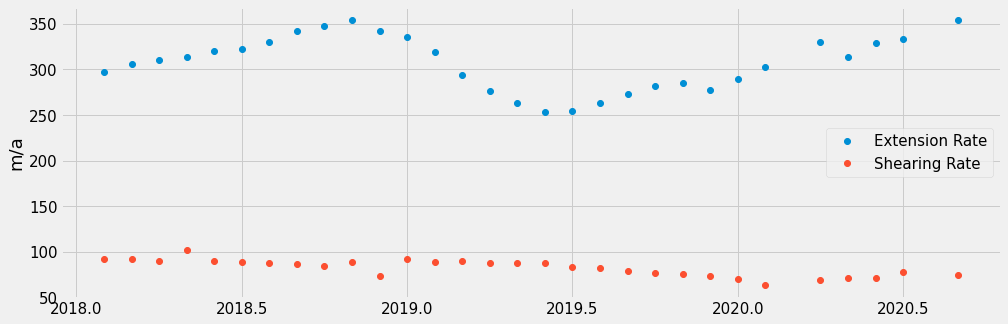

-82.47584842008847
307.3750250447601


In [17]:
# What do the GPS data look like?

t = gps.YYYY.values + gps.MM.values / 12
hh00_u = np.array(gps.PSU[ gps.Site=='HH00' ])
hh00_v = np.array(gps.PSV[ gps.Site=='HH00' ])
tt05_u = np.array(gps.PSU[ gps.Site=='TT05' ])
tt05_v = np.array(gps.PSV[ gps.Site=='TT05' ])
ss00_u = np.array(gps.PSU[ gps.Site=='SS00' ])
ss00_v = np.array(gps.PSV[ gps.Site=='SS00' ])
tt04_u = np.array(gps.PSU[ gps.Site=='TT04' ])
tt04_v = np.array(gps.PSV[ gps.Site=='TT04' ])

#
# Rotate into rift-coordinates
#


v1 = np.dot(rot, np.array([hh00_u,hh00_v])[:,0:30])
v2 = np.dot(rot, np.array([tt05_u,tt05_v])[:,0:30])
v3 = np.dot(rot, np.array([ss00_u,ss00_v])[:,0:30])
v4 = np.dot(rot, np.array([tt04_u,tt04_v])[:,0:30])

# relative_motion = (v1+v3)/2-(v2+v4)/2
relative_motion = (v1-v2)*365

plt.subplots(figsize=(15,5))
plt.plot(t[0:30],relative_motion[1,:],'o',label='Extension Rate')
plt.plot(t[0:30],-relative_motion[0,:],'o',label='Shearing Rate')
plt.legend()
plt.ylabel('m/a')

plt.show()

print(np.mean(relative_motion[0,:]))
print(np.mean(relative_motion[1,:]))

## Can we observe this the variability in stretching rate in the ICESat-2 data?

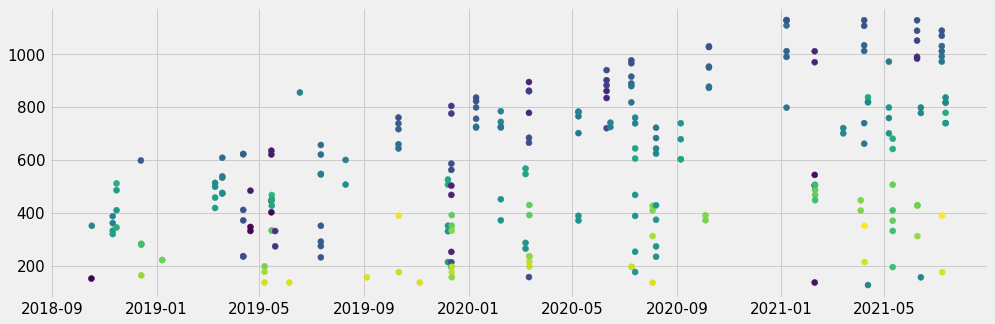

In [18]:
plt.subplots(figsize=(15,5))
plt.scatter(latest['t'],latest['w'],c=dist)

In [19]:
e11 

array([-1.06151502e-01, -1.07369723e-01, -1.15749563e-01, -1.25171402e-01,
       -1.16112724e-01, -8.51676257e-02, -5.64500718e-02, -5.93214317e-02,
       -5.43681948e-02, -2.27970128e-02, -1.43235503e-02, -8.46170136e-03,
       -2.31040164e-02, -2.28145380e-02, -2.03572384e-02, -2.08015944e-02,
       -2.26923457e-02, -2.75214957e-02, -2.95027360e-02, -3.23074726e-02,
        1.86549576e-02,  1.87316557e-02,  7.64904767e-04, -3.39816197e-02,
        4.36447047e-03, -4.77769057e-04, -2.03533017e-03, -3.70365798e-03,
       -6.19412717e-03, -4.62300571e-03,  2.15793808e-02, -7.91964365e-04,
       -4.45413587e-03, -4.60319845e-03, -6.91655696e-03, -9.49069905e-03,
       -1.76655058e-02, -2.00343784e-02, -1.95355232e-02, -1.94088386e-02,
       -1.87098954e-02, -1.77728923e-02, -1.74425101e-02, -1.59482248e-02,
       -1.44151379e-02, -1.06315372e-02, -7.94882155e-03,  3.63676384e-03,
        1.15213357e-02,  1.23209398e-02,  8.80925218e-03,  7.26020300e-03,
        4.43608775e-03,  

## Does the melange thicken with time?

Text(0, 0.5, 'Melange Thickness (m)')

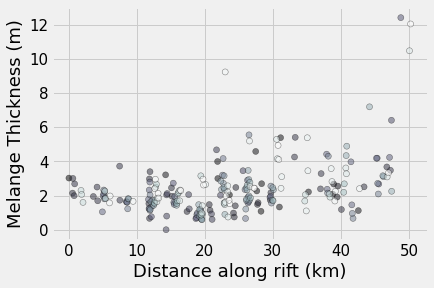

In [20]:
plt.subplots()
plt.scatter(dist/1e3,latest['h'],c=times,cmap='bone',label=latest['t'],\
                 alpha=0.5,edgecolors='k')
plt.xlabel('Distance along rift (km)')
plt.ylabel('Melange Thickness (m)')

Text(0, 0.5, 'Melange Thickness (m)')

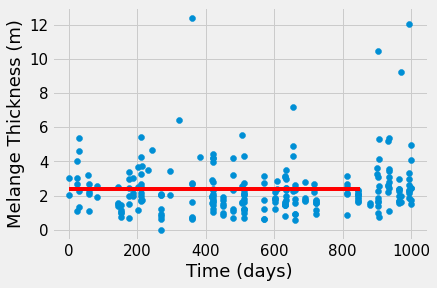

In [21]:
plt.scatter(times,latest['h'])
plt.plot((0,850),np.mean(latest['h'])*np.array((1,1)),'-r')
plt.xlabel('Time (days)')
plt.ylabel('Melange Thickness (m)')